In [1]:
# only works with sum of grassmannian chordal distances rather than chordal distance between flags.
# and SVD outpreforms other methods


import numpy as np
import scipy
import scipy.io as sio

from FlagRep0 import chordal_distance, truncate_svd
from FlagRepp import FlagRepp

from matplotlib import pyplot as plt

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import tqdm

import pandas as pd
import seaborn as sns


In [2]:
data = sio.loadmat('../data/indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected'] 
data.shape

(145, 145, 200)

In [5]:
data = sio.loadmat('../data/KSC/KSC_corrected.mat')['KSC']
data.shape

(512, 614, 176)

In [2]:

def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

def evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values):
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
        # Fit the model using the training distance matrix and labels
        knn.fit(distance_matrix_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(distance_matrix_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # print(f"k={k}, Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)
    
    return accuracies

def extract_patches_of_class(data, labels, patch_size, target_class):
    """
    Extract non-overlapping patches where all pixels in the patch are of the target class.

    :param data: The hyperspectral image data 
    :param labels: The ground truth labels 
    :param patch_size: Size of the patch (e.g., 7 for 7x7 patches).
    :param target_class: The class for which patches should be extracted.
    :return: A list of patches (each patch is of size patch_size x patch_size x num_bands).
    """
    half_patch = patch_size // 2
    patches = []
    patch_labels = []

    # Iterate through the image in steps of patch_size to avoid overlap
    for i in range(half_patch, data.shape[0] - half_patch, patch_size):
        for j in range(half_patch, data.shape[1] - half_patch, patch_size):
            # Extract the patch from both the data and the labels
            label_patch = labels[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1]
            
            # Check if all pixels in the label patch are of the target class
            if np.all(label_patch == target_class):
                # Extract the corresponding data patch
                patch = data[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1, :]
                patches.append(patch)
                patch_labels.append(target_class)

    return np.array(patches), np.array(patch_labels)




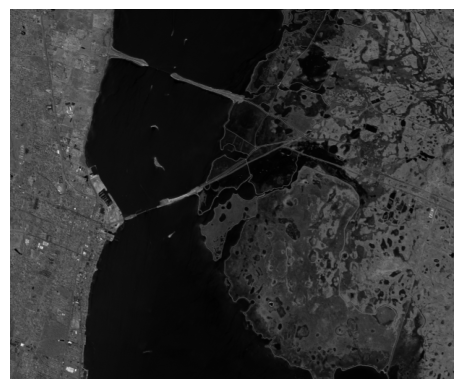

In [ ]:
data = scipy.io.loadmat('../data/KSC/KSC.mat')['KSC']
labels = scipy.io.loadmat('../data/KSC/KSC_gt.mat')['KSC_gt']


plt.figure()
plt.imshow(data[:,:,40], cmap = 'grey')
plt.axis('off')
plt.savefig('../results/KSC_1band.pdf', bbox_inches = 'tight')


(np.float64(-0.5), np.float64(49.5), np.float64(49.5), np.float64(-0.5))

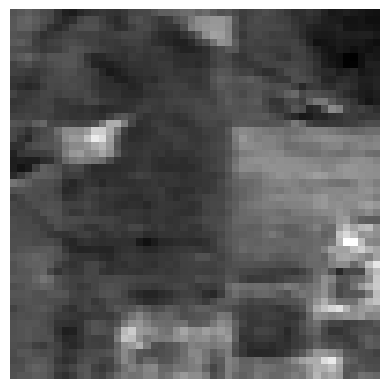

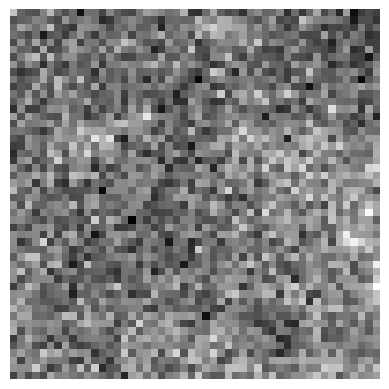

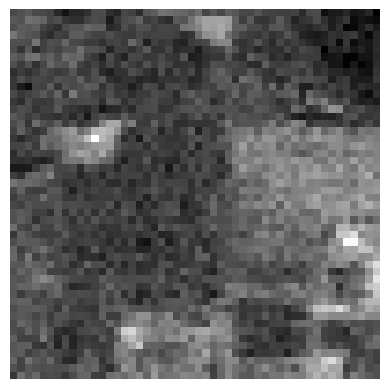

In [26]:
fl_type = [8,9,10]
height, width = (50,50)
noise_dist = 'Normal'


data = sio.loadmat('../data/indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected'] 


image_height, image_width, n_bands = data.shape
    
As = [np.arange(40), np.arange(100), np.arange(n_bands)]


noise_scale = .1
            
r_seed = 5
# Assume `image` is a NumPy array with shape (height, width, channels)

# Define the crop size
crop_height = height
crop_width = width

# Randomly select the starting point for the crop
x_start = np.random.randint(0, image_width - crop_width + 1)
y_start = np.random.randint(0, image_height - crop_height + 1)

# Crop the image
cropped_image = data[y_start:y_start + crop_height, x_start:x_start + crop_width]

n = width*height
D_true = cropped_image.reshape((width*height, n_bands))

D_true = D_true/D_true.max() #max normalization

if noise_dist == 'Normal':
    noise = np.random.normal(scale = noise_scale, size = (n,n_bands))
elif noise_dist == 'Exponential':
    noise = np.random.exponential(scale = noise_scale, size = (n,n_bands))
elif noise_dist == 'Uniform':
    noise = noise_scale*np.random.uniform(size = (n,n_bands))

D_noisy = D_true + noise

plt.figure()
plt.imshow(D_true.reshape((width, height, n_bands))[:,:,50], cmap = 'grey')
plt.axis('off')

plt.figure()
plt.imshow(D_noisy.reshape((width, height, n_bands))[:,:,50], cmap = 'grey')
plt.axis('off')


my_fr = FlagRepp(As, flag_type = fl_type)
X,R = my_fr.fit_transform(D_noisy)
D_flagrep = X @ R

plt.figure()
plt.imshow(D_flagrep.reshape((width, height, n_bands))[:,:,50], cmap = 'grey')
plt.axis('off')




In [12]:
patches.max()

np.uint16(387)